In [4]:
from dask_gateway import Gateway
from dask_gateway import GatewayCluster
from dask.distributed import Client
import starepandas
import sqlalchemy
import geopandas

In [6]:
import pystare as ps

from netCDF4 import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

import geodata as gd

import numpy

from PIL import Image
Image.MAX_IMAGE_PIXELS = None


import os
import sys
import glob
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely

%matplotlib inline
# %matplotlib notebook

In [7]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

# Some helper functions for plotting & printing.

def mnmx(a):
    return numpy.amin(a),numpy.amax(a)
def span(a):
    return numpy.amax(a)-numpy.amin(a)

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=0
        ,fixdateline=False
        ,figsize=None
        ):

    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        if dbg>0:
            print('lons: ',mnmx(lons))
            print('lats: ',mnmx(lats))
            # print('lons: ',lons)
            # print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))

    if figax is not None:
        plot_options = figax.plot_options
    
    if plot_options is None:
        if spatial_index_values is not None:
            mnx  = mnmx(lons)
            if fixdateline:
                s = span(lons)
                if s > 270:
                    clon = ((0.5 * (sum(mnx)+180))%360)-180
                else:
                    clon = 0.5*sum(mnx)
            else:
                clon = 0.5*sum(mnx)
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=clon
                    # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                             )
            ,'transform':ccrs.Geodetic()}
            if dbg>0:
                print('hp-po central_longitude: ',clon)
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=figsize),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg>0:
        return figax,lons,lat,intmat
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [ ]:
# Dask helpers
def slam(client,action,data,partition_factor=1.5):
    np = sum(client.nthreads().values())
    print('slam: np = %i'%np)
    shard_bounds = [int(i*len(data)/(1.0*partition_factor*np)) for i in range(int(partition_factor*np))] 
    if shard_bounds[-1] != len(data):
        print('a sb[-1]: ',shard_bounds[-1],len(data))
        shard_bounds = shard_bounds + [len(data)]
    print('sb: ',shard_bounds)
    data_shards = [data[shard_bounds[i]:shard_bounds[i+1]] for i in range(len(shard_bounds)-1)]
    print('ds len:        ',len(data_shards))
    print('ds item len:   ',len(data_shards[0]))
    print('ds type:       ',type(data_shards[0]))
    try:
        print('ds dtype:      ',data_shards[0].dtype)
    except:
        pass
    big_future = client.scatter(data_shards)
    results    = client.map(action,big_future)
    return results

In [2]:
gateway = Gateway()

In [3]:
gateway

Gateway<http://10.100.222.95:8000/services/dask-gateway>

In [4]:
options = gateway.cluster_options(); options

In [5]:
cluster = gateway.new_cluster(); cluster

In [6]:
clusters = gateway.list_clusters(); clusters

[ClusterReport<name=daskhub.124895b299dd46219ba7a1b3b312bd0f, status=RUNNING>]

In [7]:
gateway_uri = "gateway://traefik-dhub-dask-gateway.daskhub:80/daskhub."+gateway.list_clusters()[0].name.split('.')[1]; gateway_uri

'gateway://traefik-dhub-dask-gateway.daskhub:80/daskhub.124895b299dd46219ba7a1b3b312bd0f'

In [8]:
# client = cluster.get_client(gateway_uri);
client = cluster.get_client();

/home/jovyan/users_conda_envs/stare-2/lib/python3.7/site-packages/distributed/client.py:1136: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.19.2 | 1.19.1    | 1.19.1  |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [9]:
client

Client Scheduler: gateway://traefik-dhub-dask-gateway.daskhub:80/daskhub.124895b299dd46219ba7a1b3b312bd0f Dashboard: /services/dask-gateway/clusters/daskhub.124895b299dd46219ba7a1b3b312bd0f/status,Cluster Workers: 1 Cores: 2 Memory: 4.29 GB


In [11]:
client.nthreads()

{'tls://192.168.25.216:45663': 2}

In [2]:
source_folder = 's3://daskhub-data/MODAPS/MOD05_L2/2019/356/'
data_names,s3_info = list(starepandas.s3_glob(source_folder,pattern='.*\.hdf'))
len(data_names)

288

In [ ]:
test_names = data_names[0:3]

In [3]:
# folder = '/home/jovyan/data/'
folder = 's3://daskhub-data/MODAPS/MOD05_L2/2019/356/'
catalogue = None
catalogue = starepandas.folder2catalogue(path=folder, 
                             granule_extension='hdf',
                             add_sf=True)

Empty response from s3 for bucket daskhub-data with prefix MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0040.061.2019356132538_stare.nc
no sidecar found for s3://daskhub-data/MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0040.061.2019356132538.hdf
Empty response from s3 for bucket daskhub-data with prefix MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0135.061.2019356132223_stare.nc
no sidecar found for s3://daskhub-data/MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0135.061.2019356132223.hdf
Empty response from s3 for bucket daskhub-data with prefix MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0225.061.2019356132202_stare.nc
no sidecar found for s3://daskhub-data/MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0225.061.2019356132202.hdf
Empty response from s3 for bucket daskhub-data with prefix MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0320.061.2019356132222_stare.nc
no sidecar found for s3://daskhub-data/MODAPS/MOD05_L2/2019/356/MOD05_L2.A2019356.0320.061.2019356132222.hdf
Empty response from s3 for b

In [9]:
db_path = '/home/jovyan/data/catalogue.sqlite' 
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)
catalogue_ewkb = geopandas.io.sql._convert_to_ewkb(catalogue, 'geom', 4326)
catalogue_ewkb.to_sql(name='catalogue', con=engine, if_exists='replace', index=False)

In [11]:
# s3://daskhub-data/MODAPS/CATALOGS/MOD05_L2/2019/356/catalogue.sqlite

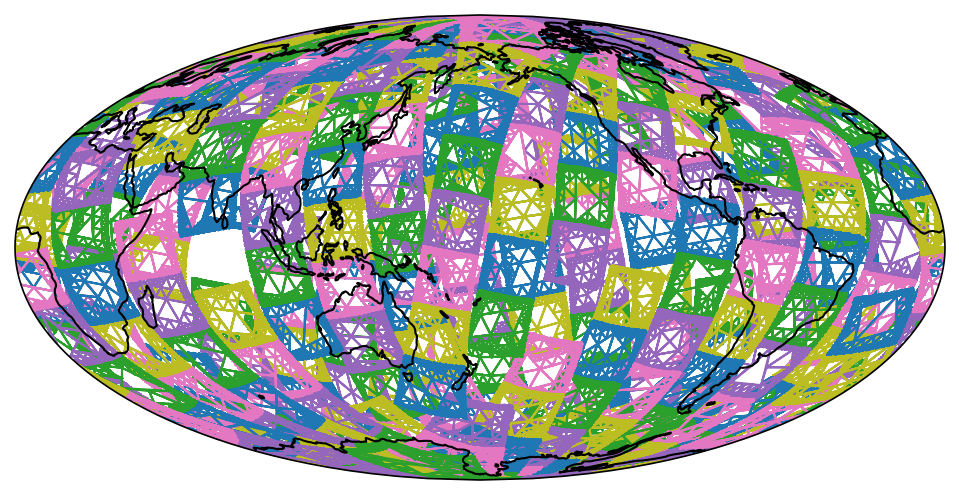

In [8]:
figax=hello_plot(set_global=True,show=False
                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
                 ,figsize=(8,8)
                )
for i in catalogue['stare_cover']:
    hello_plot(i.data,figax=figax,show=False)
plt.show()

In [12]:
cluster.shutdown()

In [14]:
cluster.close()

In [15]:
gateway.list_clusters()

[]

In [ ]:
cluster = gateway.connect(clusters[0].name)

In [ ]:
cluster.shutdown(); cluster.close()

In [14]:
gateway.close()

In [16]:
gateway.list_clusters()

[]

In [ ]:
gateway